## Load Dataset - CICFlowMeter

In [1]:
import gc
import pandas as pd
import random
import numpy as np

random.seed(123)
np.random.seed(123)

dataset_train = pd.read_csv("/home/lucianobf/dev/datasets/dataset_network_cfm/train/dataset_network_train_cfm.csv", sep = ',')
# 30% of train dataset
dataset_train = dataset_train.sample(frac=0.20, random_state=1)

dataset_test = pd.read_csv("/home/lucianobf/dev/datasets/dataset_network_cfm/test/dataset_network_test_cfm.csv", sep = ',')
# 10% of test dataset
dataset_test = dataset_test.sample(frac=0.10, random_state=1)

print("Dataset Original Shape")
print(f"Shape train: {dataset_train.shape}")
print(f"Shape test: {dataset_test.shape}")

# drop_comlumns=['Flow ID', 'Label1', 'Label2']
# drop_comlumns=['Flow ID','Flow Start Time','Flow End Time','Dst Port', 'Protocol', 
#                 'Fwd Packet Length Min','Bwd Packet Length Min','Fwd PSH Flags','Bwd PSH Flags',
#                 'Fwd URG Flags','Bwd URG Flags',
#                 'Label1', 'Label2']
drop_comlumns=['Flow ID','Flow Start Time','Flow End Time','Dst Port', 'Protocol', 
                'Fwd Packet Length Min','Bwd Packet Length Min','Fwd PSH Flags','Bwd PSH Flags',
                'Fwd URG Flags','Bwd URG Flags', 'Packet Length Min', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg',
                'Fwd Bulk Rate Avg', 'Bwd Init Win Bytes', 'Fwd Act Data Pkts',
                'Label1', 'Label2']

# # X_train, y_train, X_test, y_test
y_train = dataset_train['Label1']
y_test = dataset_test['Label1']

X_train = dataset_train.drop(columns=drop_comlumns)
X_test = dataset_test.drop(columns=drop_comlumns)

feature_names = X_train.columns.values.tolist()

del dataset_train
del dataset_test
gc.collect()


Dataset Original Shape
Shape train: (4589211, 86)
Shape test: (1257960, 86)


0

y_train
attack    3237835
normal    1351376
Name: Label1, dtype: int64
attack    0.705532
normal    0.294468
Name: Label1, dtype: float64

y_test
attack    890887
normal    367073
Name: Label1, dtype: int64
attack    0.7082
normal    0.2918
Name: Label1, dtype: float64


<Figure size 432x288 with 0 Axes>

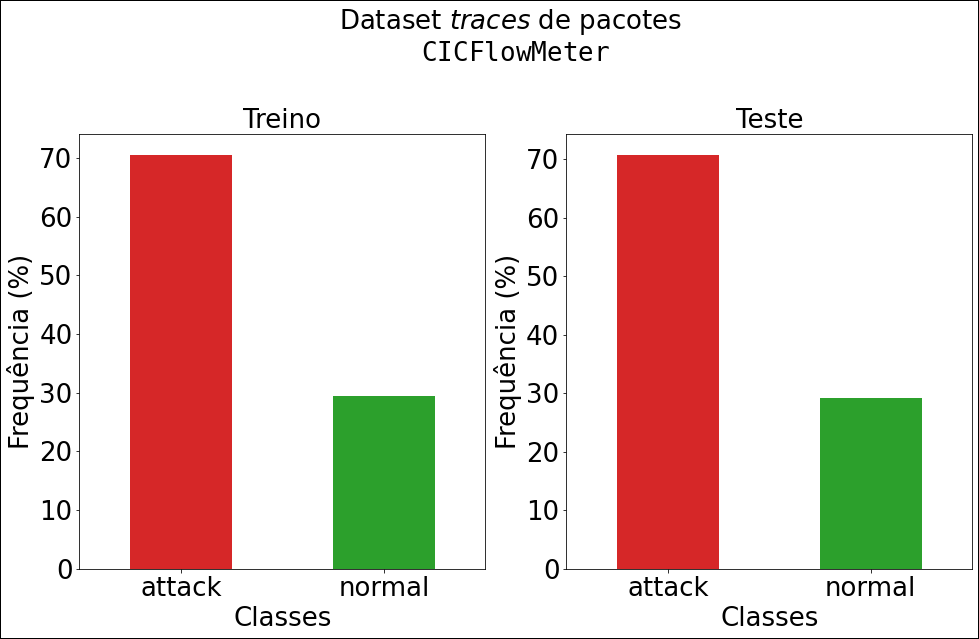

In [2]:
import matplotlib.pyplot as plt

print("y_train")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
print("")
print("y_test")
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))


plt.clf()
plt.rcParams["axes.titlesize"] = 26
plt.rc('font', size=26)
plt.rc('figure', facecolor='white')
fig, ax = plt.subplots(1,2, figsize=(16,8), linewidth=2, edgecolor="black")
for a in ax:
    a.set_ylabel("Frequência (%)")
    a.set_xlabel("Classes")

((y_train.value_counts()/y_train.count())*100).plot.bar(rot=0, ax=ax[0], color=['tab:red','tab:green'], title="Treino")
((y_test.value_counts()/y_test.count())*100).plot.bar(rot=0, ax=ax[1], color=['tab:red','tab:green'], title="Teste")
plt.suptitle("Dataset $\mathit{traces}$ de pacotes \n $\mathtt{CICFlowMeter}$", fontsize=26, y=1.1)
plt.show()


## Preprocessing

### Map y (labels) to binary

In [3]:

# Map labels
#  0 : normal
#  1 : attack

y_train = y_train.apply(lambda x : 0 if x=="normal" else (1 if x=="attack" else x))
y_test = y_test.apply(lambda x : 0 if x=="normal" else (1 if x=="attack" else x))

print("y_train")
print(y_train.value_counts())
print("")
print("y_test")
print(y_test.value_counts())


y_train
1    3237835
0    1351376
Name: Label1, dtype: int64

y_test
1    890887
0    367073
Name: Label1, dtype: int64


## Pre-processing X

### Convert IPs to int

In [4]:
import ipaddress

def convert_ip_to_int(ip):
    return int(ipaddress.IPv4Address(ip))

def convert_int_to_ip(i):
    return  


def ip_to_int(X):
    X['Src IP'] = X['Src IP'].apply(convert_ip_to_int)
    X['Dst IP'] = X['Dst IP'].apply(convert_ip_to_int)
    return X


X_train = ip_to_int(X_train)
X_test = ip_to_int(X_test)


# X_train['SrcAddr'] = X_train['SrcAddr'].apply(convert_ip_to_int)
# X_train['DstAddr'] = X_train['DstAddr'].apply(convert_ip_to_int)

# X_test['SrcAddr'] = X_test['SrcAddr'].apply(convert_ip_to_int)
# X_test['DstAddr'] = X_test['DstAddr'].apply(convert_ip_to_int)

X_train

,Src IP,Src Port,Dst IP,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,...,FWD Init Win Bytes,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
13700337,2886955277,40662,171049377,736,3,6,177.0,3650.0,177.0,59.000000,...,64240,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21189406,2886955274,4641,171049377,5405,2,1,0.0,0.0,0.0,0.000000,...,512,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2494988,2886955277,48566,171049377,26988214,5,7,177.0,3650.0,177.0,35.400000,...,501,32,366.0,0.0,366.0,366.0,26987190.0,0.0,26987190.0,26987190.0
3046938,2886955315,37690,171049377,36860870,8,6,173.0,2448.0,173.0,21.625000,...,501,32,248.0,0.0,248.0,248.0,36859742.0,0.0,36859742.0,36859742.0
18623382,2886955274,2496,171049377,424,2,1,0.0,0.0,0.0,0.000000,...,512,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6233688,2886955272,17820,171049377,1119,2,1,0.0,0.0,0.0,0.000000,...,512,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19679933,2886955314,50414,171049377,27226921,11,6,173.0,2448.0,173.0,15.727273,...,466,32,7301.0,0.0,7301.0,7301.0,27215736.0,0.0,27215736.0,27215736.0
12778005,2886955273,53736,171049377,682,2,1,0.0,0.0,0.0,0.000000,...,512,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7174160,2886955273,45668,171049377,970,2,1,0.0,0.0,0.0,0.000000,...,512,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### StandardScaler

In [5]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler() 
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

# type(X_train)

## Feature Importance

In [6]:
#Plot Feature Importances
def plot_feature_importances(feature_names, importances, yerr, dataset):
    forest_importances = pd.Series(importances, index=feature_names)
    plt.cla()
    plt.clf()
    # plt.rcParams["mathtext.fontset"] = 'dejavuserif'
    # plt.rcParams["axes.titlesize"] = 18
    # plt.rcParams["axes.labelsize"] = 16
    # plt.rc('font', size=16)
    plt.rc('figure', facecolor='white')

    fig, ax = plt.subplots(figsize=(20,10), linewidth=2, edgecolor="black")
    forest_importances.plot.bar(yerr=yerr, ax=ax)
    ax.set_title("Importância das Características - "+dataset+" \n $\mathit{Random \ Forest \ (MDI)}$")
    ax.set_ylabel("Diminuição média na impureza")
    #plt.xticks(rotation=30, ha='right', rotation_mode='anchor')
    fig.tight_layout()
    plt.show()


## Matriz Confusão

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Plot Confusion Matrix
def plot_confusion_matrix(ytest, ypred, title):
    plt.cla()
    plt.clf()
    plt.rcParams["axes.titlesize"] = 15
    plt.rc('font', size=14)
    plt.rc('figure', facecolor='white')
    disp = ConfusionMatrixDisplay.from_predictions(ytest, ypred, cmap=plt.cm.Blues, normalize='true', values_format='.2f', display_labels=['Normal','Ataque'])
    disp.ax_.set_title("normalização : linhas (real)", size=14)
    disp.figure_.suptitle(title, y=1.1, size=15)
    # disp.ax_.set_title(title)
    # xlabels = [item.get_text() for item in disp.ax_.get_xticklabels()]
    # ylabels = [item.get_text() for item in disp.ax_.get_yticklabels()]
    # xlabels[0] = 'normal'
    # xlabels[1] = 'ataque'
    # ylabels[0] = 'normal'
    # ylabels[1] = 'ataque'
    # disp.ax_.set_xticklabels(xlabels)
    # disp.ax_.set_yticklabels(ylabels)
    disp.ax_.set_xlabel("Predito", size=15)
    disp.ax_.set_ylabel("Real", size=15)
    disp.figure_.set_linewidth(2)
    disp.figure_.set_edgecolor("black")
    plt.show()

## Classifiers  

- Gaussian Naive Bayes

GaussianNB
   Acurácia: 0.98
  Precision: 1.0
         F1: 0.99
     Recall: 0.97


<Figure size 432x288 with 0 Axes>

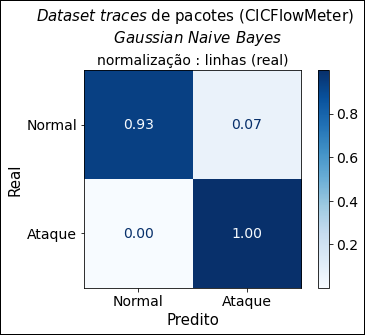

In [8]:
from sklearn.naive_bayes import GaussianNB
#from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import random
import numpy as np

random.seed(123)
np.random.seed(123)

modeloGNB = GaussianNB()

modeloGNB.fit(X_train, y_train)
ypred = modeloGNB.predict(X_test)
print(f"GaussianNB")
print(f"   Acurácia: {round(accuracy_score(ypred, y_test),2)}")
print(f"  Precision: {round(precision_score(ypred, y_test),2)}")
print(f"         F1: {round(f1_score(ypred, y_test),2)}")
print(f"     Recall: {round(recall_score(ypred, y_test),2)}")

plot_confusion_matrix(ytest=y_test, ypred=ypred, title="$\mathit{Dataset \ traces}$ de pacotes (CICFlowMeter) \n $\mathit{Gaussian \ Naive \ Bayes}$")

- RandomForestClassifier

Random Forest
   Acurácia: 1.0
  Precision: 1.0
         F1: 1.0
     Recall: 1.0


<Figure size 432x288 with 0 Axes>

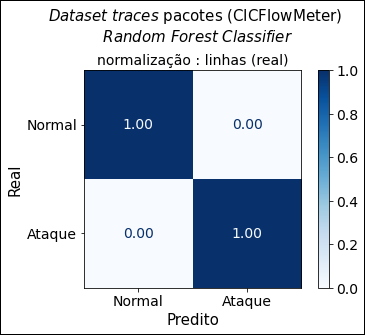

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import random
import numpy as np

random.seed(123)
np.random.seed(123)

# modeloRF = RandomForestClassifier(n_estimators=20, n_jobs=-1)
modeloRF = RandomForestClassifier(n_estimators=20)
modeloRF.fit(X_train, y_train)
ypred = modeloRF.predict(X_test)
print(f"Random Forest")
print(f"   Acurácia: {round(accuracy_score(ypred, y_test),2)}")
print(f"  Precision: {round(precision_score(ypred, y_test),2)}")
print(f"         F1: {round(f1_score(ypred, y_test),2)}")
print(f"     Recall: {round(recall_score(ypred, y_test),2)}")

plot_confusion_matrix(ytest=y_test, ypred=ypred,title="$\mathit{Dataset}$ $\mathit{traces}$ pacotes (CICFlowMeter) \n $\mathit{Random \ Forest \ Classifier}$")

feature_names = X_train.columns.values.tolist()
importances = modeloRF.feature_importances_
std = np.std([tree.feature_importances_ for tree in modeloRF.estimators_], axis=0)
# plot_feature_importances(feature_names=feature_names, importances=importances, yerr=std, dataset="$\mathit{Dataset}$ $\mathit{traces}$ pacotes (CICFlowMeter) ")